In [3]:
import sys
import calendar
import glob

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

Matplotlib is building the font cache; this may take a moment.


In [4]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Mildura': (-34.2, 142.1),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Karlamilyi National Park': (-22.7, 122.2),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

## Wind speed example

In [5]:
adjustment_file = "/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/sfcWind/2070-2099/sfcWind-qdc-multiplicative-monthly-q100-adjustment-factors_ACCESS-CM2_ssp370_r4i1p1f1_gn_2070-2099_wrt_1985-2014.nc"

In [6]:
ds_adjust = xr.open_dataset(adjustment_file)

In [7]:
lat, lon = city_lat_lon['Hobart']
point_selection = {'lat': lat, 'lon': lon}
da_af_point = ds_adjust['af'].sel(point_selection, method='nearest').compute()

In [8]:
da_af_point.attrs['long_name'] = 'multiplicative adjustment factor'

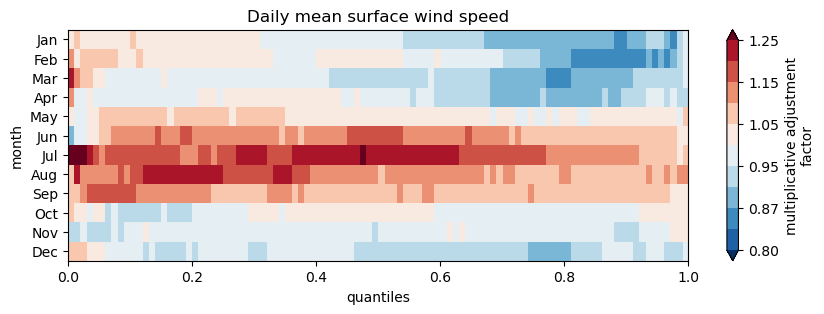

In [9]:
fig = plt.figure(figsize=[10, 3])
ax = fig.add_subplot(111)

da_af_point.transpose('month', 'quantiles').plot.imshow(
    ax=ax,
    cmap='RdBu_r',
    extend='both',
    levels=[
        round(1/1.25, 2),
        round(1/1.2, 2),
        round(1/1.15, 2),
        round(1/1.1, 2),
        round(1/1.05, 2),
        1,
        1.05,
        1.1,
        1.15,
        1.2,
        1.25,
    ]
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
ax.set_yticks(yticks, ytick_labels)
ax.invert_yaxis()
ax.set_title('Daily mean surface wind speed')

plt.savefig(
    'sfcWind-qdc-multiplicative-monthly-q100-adjustment-factors_ACCESS-CM2_ssp370_r4i1p1f1_Hobart_2070-2099_wrt_1985-2014.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

## Rainfall example

In [10]:
adjustment_file = "/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/AGCD/EC-Earth3/ssp370/r1i1p1f1/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_EC-Earth3_ssp370_r1i1p1f1_gn_2070-2099_wrt_1985-2014.nc"

In [11]:
hist_files = sorted(glob.glob("/g/data/oi10/replicas/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/pr/gr/v20200310/pr_day_EC-Earth3_historical_r1i1p1f1_gr_*.nc"))
ref_files = sorted(glob.glob("/g/data/oi10/replicas/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20200310/pr_day_EC-Earth3_ssp370_r1i1p1f1_gr_*.nc"))
target_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

In [12]:
ds_hist = utils.read_data(
    hist_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_hist = ds_hist.drop_vars('crs')
except ValueError:
    pass

In [13]:
ds_ref = utils.read_data(
    ref_files,
    'pr',
    time_bounds=['2070', '2099'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_ref = ds_ref.drop_vars('crs')
except ValueError:
    pass

In [14]:
ds_target = utils.read_data(
    target_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_target = ds_target.drop_vars('crs')
except ValueError:
    pass

In [15]:
ds_adjust = xr.open_dataset(adjustment_file)

In [16]:
lat, lon = city_lat_lon['Alice Springs']
point_selection = {'lat': lat, 'lon': lon}

In [17]:
da_af_point = ds_adjust['af'].sel(point_selection, method='nearest').compute()

In [18]:
da_hist_point = ds_hist['pr'].sel(point_selection, method='nearest')
da_ref_point = ds_ref['pr'].sel(point_selection, method='nearest')
da_target_point = ds_target['pr'].sel(point_selection, method='nearest')

In [19]:
month = 5

In [20]:
da_af_point_month = da_af_point.sel({'month': month})

In [21]:
da_hist_point_month = da_hist_point[da_hist_point['time'].dt.month == month].compute()
da_ref_point_month = da_ref_point[da_ref_point['time'].dt.month == month].compute()
da_target_point_month = da_target_point[da_target_point['time'].dt.month == month].compute()

In [29]:
quantiles = ds_adjust['quantiles'].data
da_hist_q_point_month = utils.get_quantiles(da_hist_point_month.round(5), quantiles, timescale='annual')
da_ref_q_point_month = utils.get_quantiles(da_ref_point_month.round(5), quantiles, timescale='annual')
da_target_q_point_month = utils.get_quantiles(da_target_point_month.round(5), quantiles, timescale='annual')

In [30]:
da_af_point_month = da_af_point_month.expand_dims(dim={'month': 1})
da_hist_q_point_month = da_hist_q_point_month.expand_dims(dim={'month': 1})
da_ref_q_point_month = da_ref_q_point_month.expand_dims(dim={'month': 1})
da_target_q_point_month = da_target_q_point_month.expand_dims(dim={'month': 1})

In [31]:
da_af_point_month.attrs['long_name'] = 'multiplicative adjustment factor'

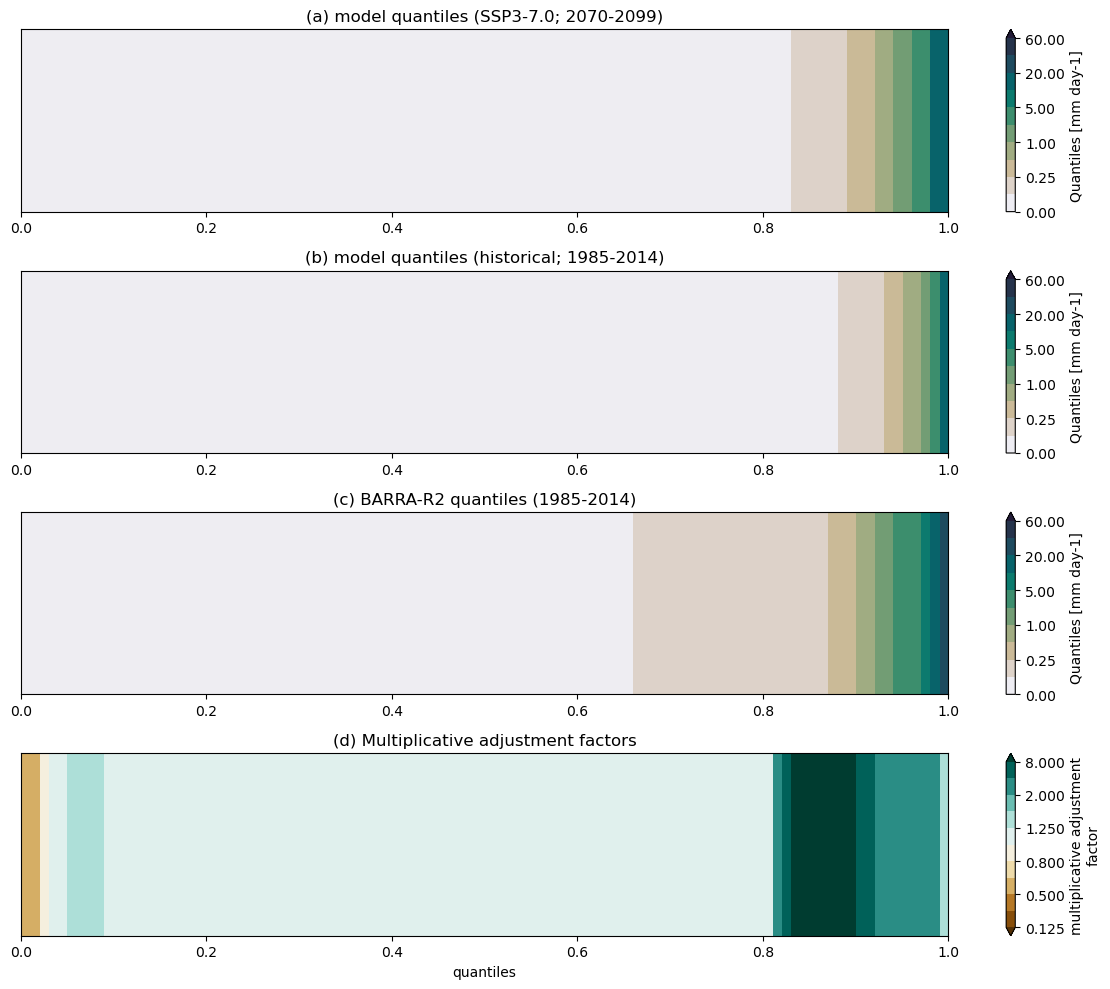

In [32]:
fig = plt.figure(figsize=[12, 10])
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

#reference quantiles
da_ref_q_point_month.transpose('month', 'quantiles').plot.imshow(
    ax=ax1,
    cmap=cmocean.cm.rain,
    extend='max',
    levels=[0, 0.01, 0.25, 0.5, 1, 2, 5, 10, 20, 40, 60],
)    
ax1.set_title('(a) model quantiles (SSP3-7.0; 2070-2099)')
ax1.set_xlabel('')
ax1.set_yticks([1], [])
ax1.set_ylabel('')

#historical quantiles
da_hist_q_point_month.transpose('month', 'quantiles').plot.imshow(
    ax=ax2,
    cmap=cmocean.cm.rain,
    extend='max',
    levels=[0, 0.01, 0.25, 0.5, 1, 2, 5, 10, 20, 40, 60],
)  
ax2.set_title('(b) model quantiles (historical; 1985-2014)')
ax2.set_xlabel('')
ax2.set_yticks([1], [])
ax2.set_ylabel('')

#historical quantiles
da_target_q_point_month.transpose('month', 'quantiles').plot.imshow(
    ax=ax3,
    cmap=cmocean.cm.rain,
    extend='max',
    levels=[0, 0.01, 0.25, 0.5, 1, 2, 5, 10, 20, 40, 60],
)  
ax3.set_title('(c) BARRA-R2 quantiles (1985-2014)')
ax3.set_xlabel('')
ax3.set_yticks([1], [])
ax3.set_ylabel('')

#adjustment factors
da_af_point_month.transpose('month', 'quantiles').plot.imshow(
    ax=ax4,
    cmap='BrBG',
    extend='both',
    levels=[0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
)    
ax4.set_title('(d) Multiplicative adjustment factors')
ax4.set_yticks([1], [])
ax4.set_ylabel('')

fig.tight_layout()

plt.savefig(
    'pr-qdc-multiplicative-monthly-q100-adjustment-factors_EC-Earth3_ssp370_r1i1p1f1_AliceSprings-May_2070-2099_wrt_1985-2014.nc.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()